In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.sparse import coo_matrix
# from scipy.io import mmwrite

In [2]:
def band_and_random(length, band_size, sparsity, p=None):
    """Dense diagonal band and random off diagonal sparsity."""
    # Randomly sample from the portion of the lower triangle not
    # including the dense band. Note that zero values in the mask
    # denote the values that are kept.
    x = length - band_size
    random_triangle_size = int(x * (x + 1) / 2)
    
    nonzero = int(round(random_triangle_size * (1 - sparsity)))
    mask_indices = np.random.choice(random_triangle_size, nonzero, replace=False, p=p)
    mask = np.zeros([random_triangle_size])
    mask[mask_indices] = 1.0
    
    # NOTE: Numpy uses 0 in np.tri to denote the diagonal, so passing 'x'
    # will create a band of size `x + 1`.
    band = np.tri(length, length, band_size - 1).T * np.tri(length, length, 0)
    
    out = np.tri(length, length, -band_size)
    out[out == 1] = mask
    out += band
    # out = -1e9 * (1.0 - out)
    return out


In [3]:
def band_and_decay(length, band_size, sparsity):
    """Dense diagonal band and random decaying off diagonal sparsity."""
    idxs = np.tril_indices(length, -band_size)

    # Weight each point by it's distance from the diagonal.
    weights = idxs[0] - idxs[1]

    # Weight decays linearly with distance from the diagonal.
    weights = np.true_divide(1.0, weights + 1e-5)

    # Normalize the weights and create the matrix.
    weights = np.true_divide(weights, np.sum(weights))
    return band_and_random(length, band_size, sparsity, p=weights)


In [4]:
def generate_sparse_attention_mask(sequence_length, sparse_attention_type, band_size, sparsity):
    """Generate the sparse attention mask."""
    if sparse_attention_type == "band_and_decay":
        mask = band_and_decay(sequence_length, band_size, sparsity)
    elif sparse_attention_type == "band_and_random":
        mask = band_and_random(sequence_length, band_size, sparsity)
    else:
        raise ValueError("Unknown attention type '{}'.".format(sparse_attention_type))
    mask = np.reshape(mask.astype(np.float32), [1, 1, sequence_length, sequence_length])

    plt.imshow(mask[0,0], cmap='gray', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Sparse Attention Mask\ntype={sparse_attention_type}\nseq_len={sequence_length} / band_size={band_size} / sparsity={sparsity}")
    plt.show()

    # # Create symbolic view of the mask
    # symbolic = np.where(maska[0, 0] == -1e9, '.', '#')
    
    # # Convert each row to string and print
    # for row in symbolic:
    #     print(''.join(row))

    # filename = f'sparse_mask_{sparse_attention_type}_sl{sequence_length}_b{band_size}_sp{sparsity}.mtx'
    # save_mask_to_mtx(mask, filename)
    return mask


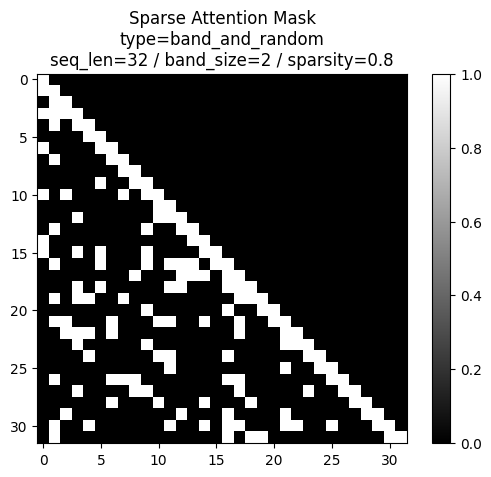

In [5]:
sequence_length = 32
sparse_attention_type = 'random'
band_size = 2
sparsity = 0.8

mask = generate_sparse_attention_mask(sequence_length, f'band_and_{sparse_attention_type}', band_size, sparsity)